In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
from statsbombpy import sb
import pandas as pd
import random

In [3]:
# Find 2022 World Cup competition_id
competitions = sb.competitions()
competitions = competitions[
    (competitions['country_name'] == 'International') & (competitions['season_name'] == '2022')]
competitions.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925


In [5]:
#Find Round of 16 match matches
df = sb.matches(competition_id=43, season_id=106)
df = df[['match_id', 'home_team', 'away_team','competition_stage']].sort_values(by='competition_stage', ascending=True).loc[df['competition_stage'] == 'Round of 16']
df

,match_id,home_team,away_team,competition_stage
24,3869219,Japan,Croatia,Round of 16
25,3869253,Brazil,South Korea,Round of 16
26,3869152,France,Poland,Round of 16
27,3869117,Netherlands,United States,Round of 16
16,3869254,Portugal,Switzerland,Round of 16
1,3869151,Argentina,Australia,Round of 16
23,3869220,Morocco,Spain,Round of 16
17,3869118,England,Senegal,Round of 16


In [7]:
# Round of 16 match ids
R16_match_ids = df['match_id'].tolist()

parser = Sbopen()

# Print list of Goalkeepers
all_dfs = []

# Loop through the match IDs and fetch the event data
for match_id in R16_match_ids:
    try:
        # Fetch the event data for each match ID
        df, related, freeze, tactics = parser.event(match_id)
        
        # Append the results to the lists
        all_dfs.append(df)
    except Exception as e:
        print(f"Error retrieving data for match {match_id}: {e}")

# Concatenate all the DataFrames into one final DataFrame
final_df = pd.concat(all_dfs, ignore_index=True)


# Round of 16 goalkeepers
unique_player_names = final_df[['player_name', 'goalkeeper_position_name', 'goalkeeper_position_id']].dropna()['player_name'].unique()
print(unique_player_names)

['Dominik Livaković' 'Shūichi Gonda' 'Seung-Gyu Kim'
 'Alisson Ramsés Becker' 'Weverton Pereira da Silva' 'Wojciech Szczęsny'
 'Hugo Lloris' 'Andries Noppert' 'Matthew Charles Turner'
 'Diogo Meireles Costa' 'Yann Sommer' 'Mathew Ryan'
 'Damián Emiliano Martínez' 'Unai Simón Mendibil' 'Yassine Bounou'
 'Edouard Mendy' 'Jordan Pickford']


In [9]:
# Count the number of goalkeepers
len(unique_player_names)


17

In [11]:
# Initialize an empty list to store DataFrames for each match
all_passes = []

# Loop through the match IDs and fetch the event data for each match
for match_id in R16_match_ids:
    try:
        # Fetch event data using the parser
        df, related, freeze, tactics = parser.event(match_id)
        
        # Filter passes and exclude 'Throw-in' from the sub_type_name column
        passes = df.loc[df['type_name'] == 'Pass'].loc[df['sub_type_name'] != 'Throw-in']
        
        # Set 'id' as the index for the DataFrame
        passes = passes.set_index('id')
        
        # Append the result to the list
        all_passes.append(passes)
        
    except Exception as e:
        print(f"Error retrieving data for match {match_id}: {e}")

# Concatenate all the DataFrames into a single DataFrame
final_df = pd.concat(all_passes, ignore_index=True)

#Prepare the dataframe of passes that were no-throw ins
df_passes = final_df.query("type_name == 'Pass' and sub_type_name != 'Throw-in'")[['x', 'y', 'end_x', 'end_y', 'player_name']]
df_passes

,x,y,end_x,end_y,player_name
0,61.0,40.1,34.5,45.7,Andrej Kramarić
1,36.3,44.8,95.0,15.8,Dejan Lovren
2,95.0,15.8,102.2,16.8,Bruno Petković
3,102.2,16.8,110.9,21.2,Ivan Perišić
4,110.9,21.2,110.9,36.6,Mateo Kovačić
...,...,...,...,...,...
9056,56.4,11.6,47.9,47.5,Fodé Ballo Touré
9057,54.0,41.0,102.1,12.5,Nampalys Mendy
9058,120.0,0.1,115.6,38.1,Pape Matar Sarr
9059,108.7,4.8,105.0,14.7,Pape Matar Sarr


In [13]:
# Filter out goalkeepers who have made less than 6 passes
filtered_player_names = [
    name for name in unique_player_names
    if df_passes['player_name'].value_counts().get(name, 0) > 6
]

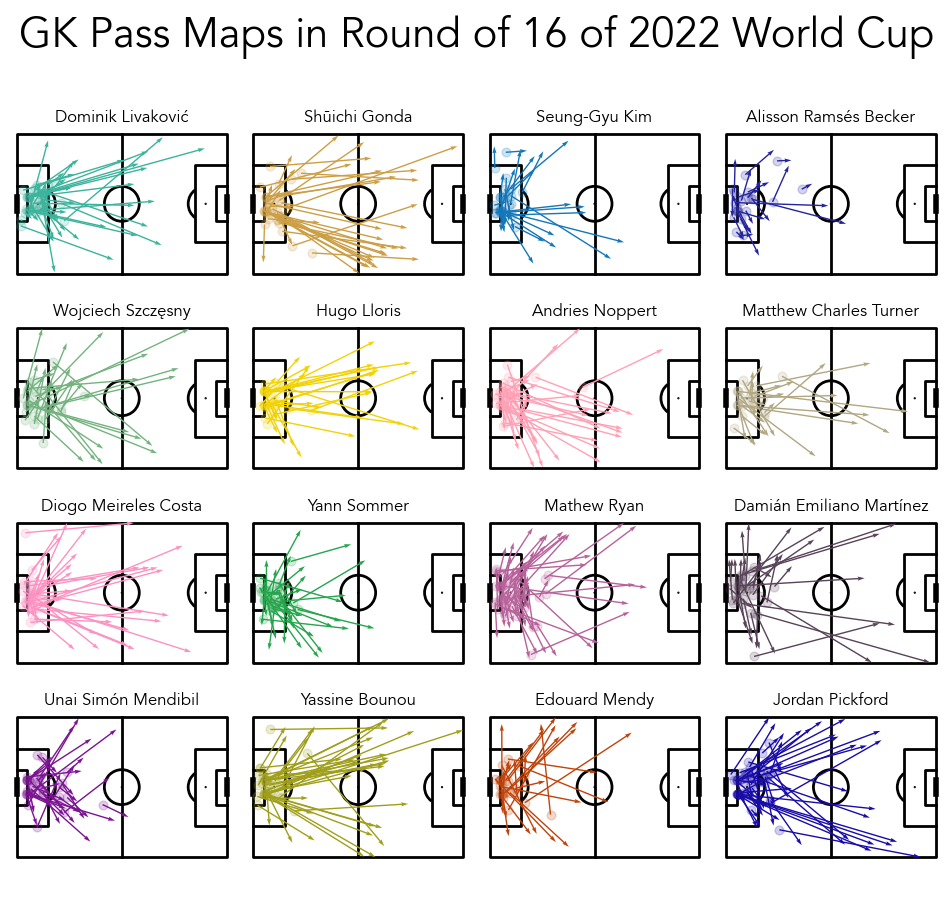

In [19]:
# Create the 4x4 pitch grid 
pitch = Pitch(line_color='black', pad_top=20)
fig, axs = pitch.grid(ncols=4, nrows=4, grid_height=0.85, title_height=0.06, axis=False,
                      endnote_height=0.04, title_space=0.04, endnote_space=0.01)

# Create a list of unique colors (e.g., using a colormap or random colors)
def generate_random_color():
    return f'#{random.randint(0, 0xFFFFFF):06x}'

# Assign a random color to each plot
    color = generate_random_color()

# Loop through the filtered list of player names and assign a unique color to each graph
for i, (name, ax) in enumerate(zip(filtered_player_names, axs['pitch'].flat[:len(filtered_player_names)])):
    # Ensure that color is defined
    color = generate_random_color()  # Generate a random color for each player

    # Put player name over the plot
    ax.text(60, -10, name, ha='center', va='center', fontsize=12, font="Avenir")
    
    # Take only passes by this player
    player_df = df_passes.loc[df_passes["player_name"] == name]
    
    # Scatter plot for the player's passes with the assigned unique color
    pitch.scatter(player_df.x, player_df.y, alpha=0.2, s=40, color=color, ax=ax)
    
    # Plot arrows for the passes with the assigned unique color
    pitch.arrows(player_df.x, player_df.y, player_df.end_x, player_df.end_y, color=color, ax=ax, width=1)

# Set title for the whole figure using mplsoccer
axs['title'].text(0.5, 0.5, 'GK Pass Maps in Round of 16 of 2022 World Cup', ha='center', va='center', font="Avenir", fontsize =30)

# Show the plot
plt.show()
